In [1]:
import gensim.downloader as api

# Download the pre-trained GloVe model with 50-dimensional vectors
model = api.load('glove-wiki-gigaword-50')

[==================================================] 100.0% 66.0/66.0MB downloaded
Vector for "king":
[ 0.50451   0.68607  -0.59517  -0.022801  0.60046  -0.13498  -0.08813
  0.47377  -0.61798  -0.31012  -0.076666  1.493    -0.034189 -0.98173
  0.68229   0.81722  -0.51874  -0.31503  -0.55809   0.66421   0.1961
 -0.13495  -0.11476  -0.30344   0.41177  -2.223    -1.0756   -1.0783
 -0.34354   0.33505   1.9927   -0.04234  -0.64319   0.71125   0.49159
  0.16754   0.34344  -0.25663  -0.8523    0.1661    0.40102   1.1685
 -1.0137   -0.21585  -0.15155   0.78321  -0.91241  -1.6106   -0.64426
 -0.51042 ]


In [26]:
# Access vector for a specific word
word = 'king'
vector = model[word]

# Print the vector
print(f'Vector for "{word}":\n{vector}')
vocab_size = len(model.key_to_index)
print(f'Vocabulary Size: {vocab_size}')

similar_words = model.most_similar('king', topn=5)
print(f'Most similar words to "king":\n{similar_words}')


Vector for "king":
[ 0.50451   0.68607  -0.59517  -0.022801  0.60046  -0.13498  -0.08813
  0.47377  -0.61798  -0.31012  -0.076666  1.493    -0.034189 -0.98173
  0.68229   0.81722  -0.51874  -0.31503  -0.55809   0.66421   0.1961
 -0.13495  -0.11476  -0.30344   0.41177  -2.223    -1.0756   -1.0783
 -0.34354   0.33505   1.9927   -0.04234  -0.64319   0.71125   0.49159
  0.16754   0.34344  -0.25663  -0.8523    0.1661    0.40102   1.1685
 -1.0137   -0.21585  -0.15155   0.78321  -0.91241  -1.6106   -0.64426
 -0.51042 ]
Vocabulary Size: 400000
Most similar words to "king":
[('prince', 0.8236179351806641), ('queen', 0.7839043140411377), ('ii', 0.7746230363845825), ('emperor', 0.7736247777938843), ('son', 0.766719400882721)]


In [31]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Permute
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense
from sklearn.decomposition import PCA
import seaborn as sns


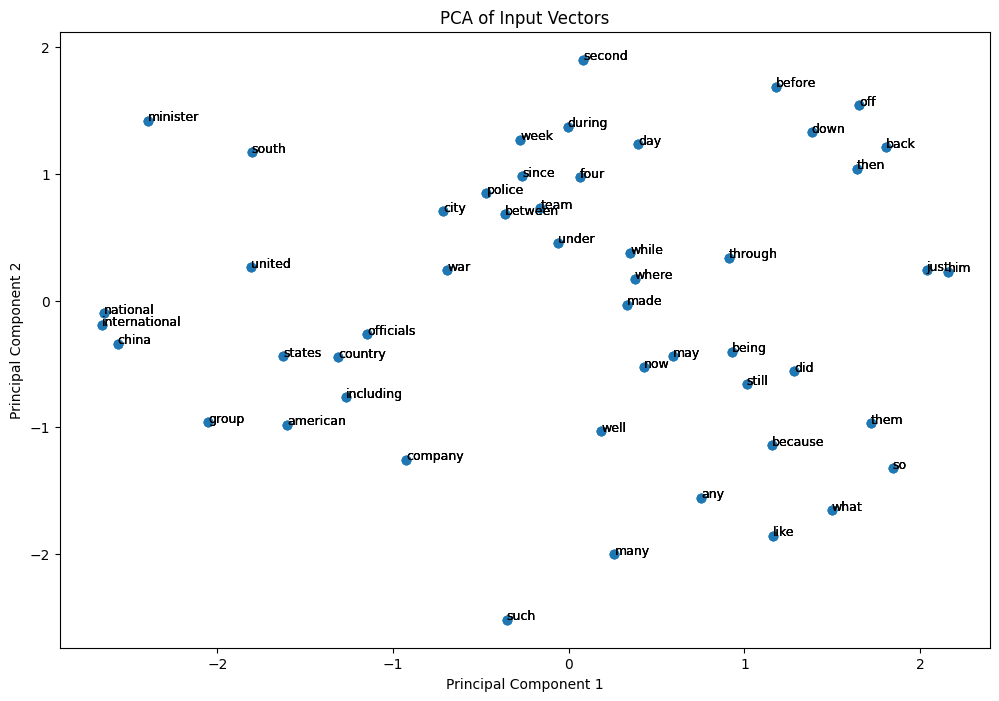

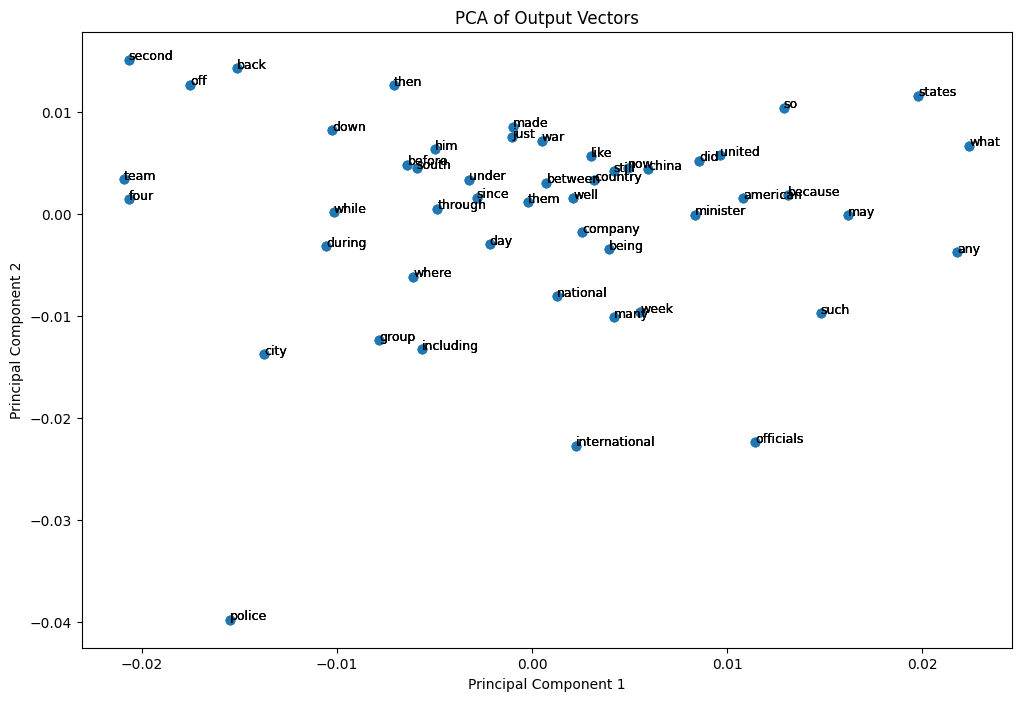

In [42]:
all_words = list(model.key_to_index.keys())
num_words = 150  # Adjust this to the number of words you want to use
words = all_words[100:num_words]

# Retrieve vectors for these words
vectors = np.array([model[word] for word in words])

# Define hyperparameters
batch_size = 3
seq_length = len(words)
embed_size = vectors.shape[1]

# Extend vectors to fit batch_size and seq_length
vectors = np.tile(vectors, (batch_size, 1, 1))

# Define multi-head attention functions
def scaled_dot_product_attention(q, k, v, d_k):
    scores = tf.matmul(q, k, transpose_b=True) / tf.sqrt(tf.cast(d_k, tf.float32))
    weights = tf.nn.softmax(scores, axis=-1)
    output = tf.matmul(weights, v)
    return output


'''
Reshapes the input tensor x to facilitate parallel computation for multiple heads. 
It rearranges the tensor to have separate dimensions for the number of heads and the depth of each head.
'''
def reshape_for_multihead(x, heads):
    batch_size, seq_length, d_model = x.shape
    depth = d_model // heads
    x = tf.reshape(x, (batch_size, seq_length, heads, depth))
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    return x

def revert_reshape(x, heads):
    batch_size, heads, seq_length, depth = x.shape
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    x = tf.reshape(x, (batch_size, seq_length, heads * depth))
    return x

def multi_head_attention(queries, keys, values, h, d_k, d_v, d_model):
    W_q = Dense(d_k * h)
    W_k = Dense(d_k * h)
    W_v = Dense(d_v * h)
    W_o = Dense(d_model)

    q = W_q(queries)
    k = W_k(keys)
    v = W_v(values)

    q_reshaped = reshape_for_multihead(q, h)
    k_reshaped = reshape_for_multihead(k, h)
    v_reshaped = reshape_for_multihead(v, h)

    
    o_reshaped = scaled_dot_product_attention(q_reshaped, k_reshaped, v_reshaped, d_k)
    
    output = revert_reshape(o_reshaped, h)
    #Combining Heads
    return W_o(output)

# Define multi-head attention hyperparameters
h = 8  # Number of attention heads
d_k = 50  # Dimension of the key vectors
d_v = 50  # Dimension of the value vectors
d_model = 50  # Dimension of the model

# Prepare tensors for queries, keys, and values
queries = tf.convert_to_tensor(vectors, dtype=tf.float32)
keys = tf.convert_to_tensor(vectors, dtype=tf.float32)
values = tf.convert_to_tensor(vectors, dtype=tf.float32)

# Apply multi-head attention
output = multi_head_attention(queries, keys, values, h, d_k, d_v, d_model)

output_vectors = output.numpy().reshape(batch_size * seq_length, d_model)
# Prepare input vectors for PCA
input_vectors = vectors.reshape(batch_size * seq_length, embed_size)

# PCA and visualization function
def plot_pca_vectors(vectors, words, title):
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(vectors)

    plt.figure(figsize=(12, 8))
    plt.scatter(principal_components[:, 0], principal_components[:, 1])

    for i, word in enumerate(words):
        plt.text(principal_components[i, 0], principal_components[i, 1], word, fontsize=9)
    
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

# Words for labeling
words_for_pca = words * batch_size  # Repeat words for each sequence in the batch

# Plot PCA for input vectors
plot_pca_vectors(input_vectors, words_for_pca, 'PCA of Input Vectors')

# Plot PCA for output vectors
plot_pca_vectors(output_vectors, words_for_pca, 'PCA of Output Vectors')# Get all words from the model


In [43]:
words

['so',
 'them',
 'what',
 'him',
 'united',
 'during',
 'before',
 'may',
 'since',
 'many',
 'while',
 'where',
 'states',
 'because',
 'now',
 'city',
 'made',
 'like',
 'between',
 'did',
 'just',
 'national',
 'day',
 'country',
 'under',
 'such',
 'second',
 'then',
 'company',
 'group',
 'any',
 'through',
 'china',
 'four',
 'being',
 'down',
 'war',
 'back',
 'off',
 'south',
 'american',
 'minister',
 'police',
 'well',
 'including',
 'team',
 'international',
 'week',
 'officials',
 'still']

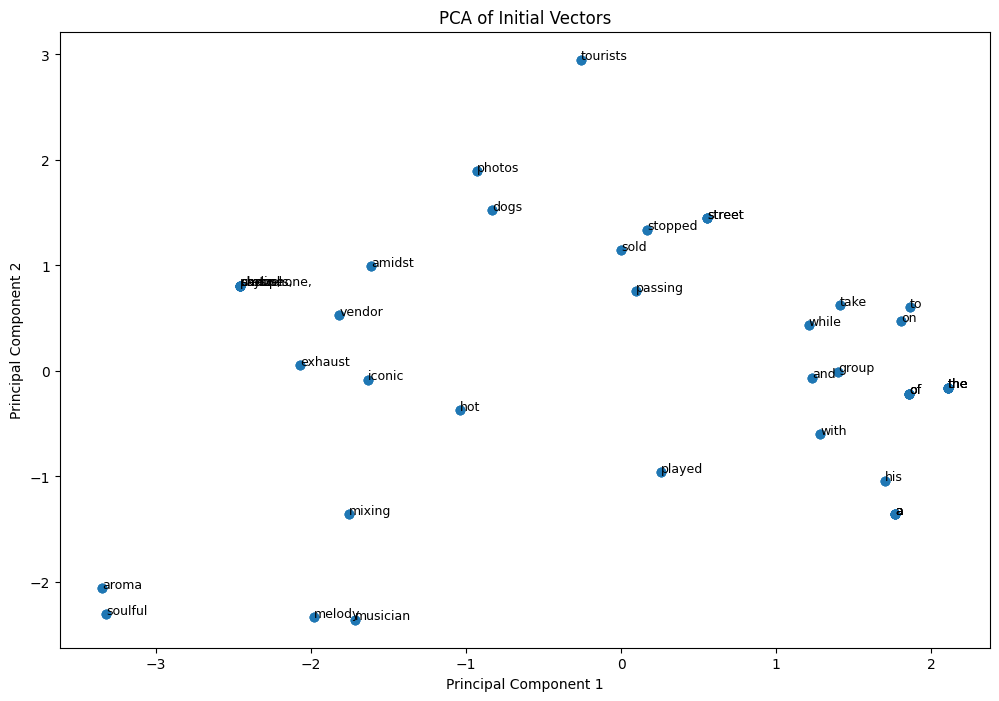

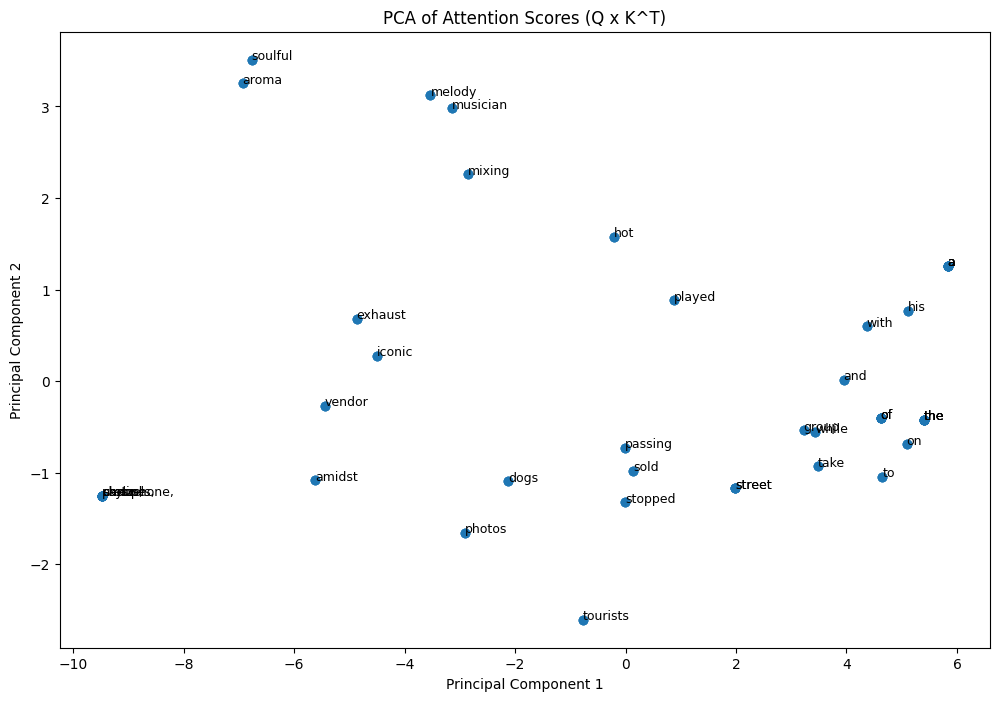

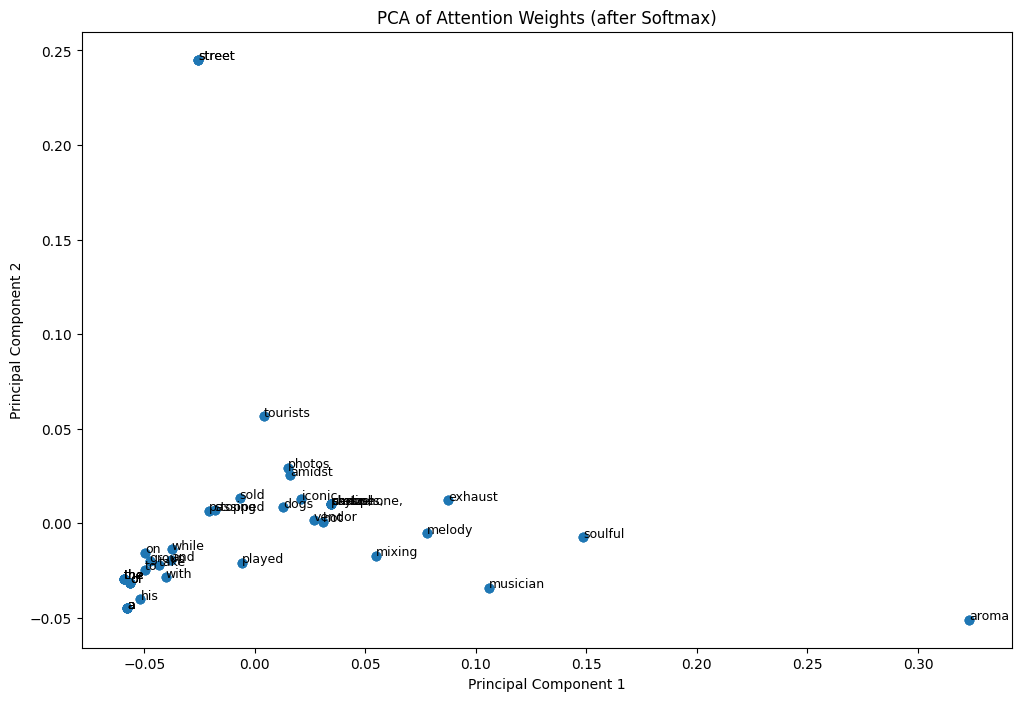

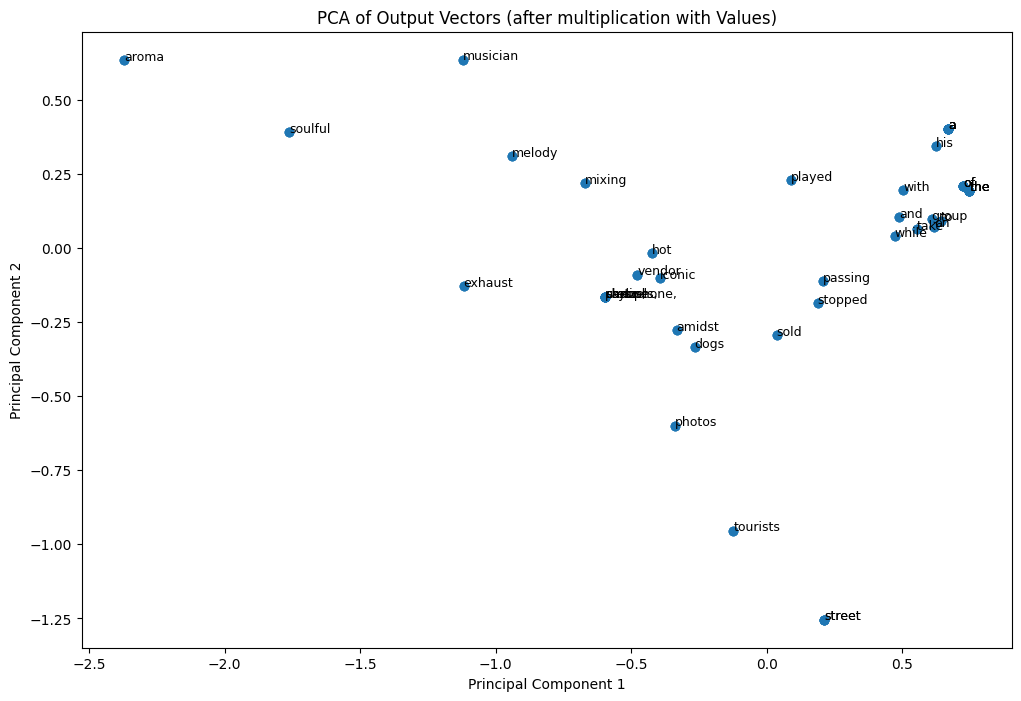

In [53]:

# Define a sentence and retrieve its vectors
sentence = (
    "A street musician played a soulful melody on his saxophone, while a group of tourists "
    "stopped to take photos of the iconic skyline. Amidst the chaos, a street vendor "
    "sold hot dogs and pretzels, the aroma mixing with the exhaust of passing cars."
)
words = sentence.lower().split()
vectors = np.array([model[word] if word in model.key_to_index else np.zeros(model.vector_size) for word in words])

# Define hyperparameters

batch_size = 3  
seq_length = len(words)
embed_size = vectors.shape[1]

# Extend vectors to fit batch_size and seq_length
vectors = np.tile(vectors, (batch_size, 1, 1)) # Shape: (batch_size, seq_length, embed_size)

# Define scaled dot product attention function
def scaled_dot_product_attention(q, k, v, d_k):
    scores = tf.matmul(q, k, transpose_b=True) / tf.sqrt(tf.cast(d_k, tf.float32))
    weights = tf.nn.softmax(scores, axis=-1)
    output = tf.matmul(weights, v)
    return scores, weights, output

# Define PCA and visualization function
def plot_pca_vectors(vectors, title, words=None):
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(vectors.reshape(-1, vectors.shape[-1]))

    plt.figure(figsize=(12, 8))
    plt.scatter(principal_components[:, 0], principal_components[:, 1])

    if words is not None:
        for i, word in enumerate(words):
            plt.text(principal_components[i, 0], principal_components[i, 1], word, fontsize=9)
    
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

# Prepare tensors for queries, keys, and values
queries = tf.convert_to_tensor(vectors, dtype=tf.float32)
keys = tf.convert_to_tensor(vectors, dtype=tf.float32)
values = tf.convert_to_tensor(vectors, dtype=tf.float32)
d_k = embed_size

# Compute attention scores, weights, and output
scores, weights, output = scaled_dot_product_attention(queries, keys, values, d_k)

# Convert tensors to numpy for visualization
scores_np = scores.numpy().reshape(batch_size * seq_length, seq_length)
weights_np = weights.numpy().reshape(batch_size * seq_length, seq_length)
output_np = output.numpy().reshape(batch_size * seq_length, embed_size)

# PCA visualization
plot_pca_vectors(vectors, 'PCA of Initial Vectors', words)
plot_pca_vectors(scores_np, 'PCA of Attention Scores (Q x K^T)', words)
plot_pca_vectors(weights_np, 'PCA of Attention Weights (after Softmax)', words)
plot_pca_vectors(output_np, 'PCA of Output Vectors (after multiplication with Values)', words)
